# Introduce

## Goals
In this notebook I'll attempt to build models to correctly predict the author of a given article. The scope will be limited to 10 authors.\
The techniques I'll use will include Tf-idf Analysis for feature-generation, and Supervised Learning (Keras library) for classification.

## Dataset
From: [snapcrack/all-the-news](https://www.kaggle.com/snapcrack/all-the-news)

This dataset contains news articles scraped from various publications, labeled by publication and author name, as well as date and title. The original source on [kaggle.com](https://www.kaggle.com) contains three `.csv` files. Accross the three, there are over 140,000 articles from a total of 15 publications.

# Code Time

### Import Libraries

In [1]:
from os import walk
from os import path
# --------- Data processing --------- #
import numpy as np # linear algebra
import pandas as pd
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# --------- Model design --------- #
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from keras import Sequential
# --------- Visualization --------- #
from wordcloud import WordCloud
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

### Input data

In [2]:
data_path = []
for dirname, _, filenames in walk('/kaggle/input'):
    for filename in filenames:
        data_path.append(path.join(dirname, filename))

data_path = iter(data_path)
# add all csv in to dataframe
dataframes = (pd.read_csv(data) for data in data_path)

# show all dataframe in one dataframe
df = pd.concat(dataframes, ignore_index=True, sort=False)

# drop useless cloumn
df.drop(['Unnamed: 0', 'url', 'id', 'year', 'month'], axis=1, inplace=True)

#### Delete useless variables

In [3]:
del dataframes, data_path, dirname, filename, filenames

### first meet with data

In [4]:
print('\033[93m Info:\033[30m')
print(df.info())
print('\033[93m Nan of each column:\033[30m')
print(df.isna().sum())
print('\033[93m Count of unique author:\033[30m', end=' ')
print(len(df.author.unique()))
print('\033[91m NOTE: we use only top 10 of authors\033[30m')

# Preview data
df.head()

 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142570 entries, 0 to 142569
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   title        142568 non-null  object
 1   publication  142570 non-null  object
 2   author       126694 non-null  object
 3   date         139929 non-null  object
 4   content      142570 non-null  object
dtypes: object(5)
memory usage: 5.4+ MB
None
 Nan of each column:
title              2
publication        0
author         15876
date            2641
content            0
dtype: int64
 Count of unique author: 15648
 NOTE: we use only top 10 of authors


,title,publication,author,date,content
0,Patriots Day Is Best When It Digs Past the Her...,Atlantic,David Sims,2017-01-11,"Patriots Day, Peter Berg’s new thriller that r..."
1,A Break in the Search for the Origin of Comple...,Atlantic,Ed Yong,2017-01-11,"In Norse mythology, humans and our world were ..."
2,Obama’s Ingenious Mention of Atticus Finch,Atlantic,Spencer Kornhaber,2017-01-11,“If our democracy is to work in this increasin...
3,"Donald Trump Meets, and Assails, the Press",Atlantic,David A. Graham,2017-01-11,Updated on January 11 at 5:05 p. m. In his fir...
4,Trump: ’I Think’ Hacking Was Russian,Atlantic,Kaveh Waddell,2017-01-11,Updated at 12:25 p. m. After months of equivoc...


### Extract 10 class from dataset

In [5]:
# we use only top 10 of authors for classification
top_wirter = df.author.value_counts()[:10] 

# Drop rows that are not in the top_writer
df_top = pd.DataFrame(columns=df.columns)
for i in top_wirter.keys():
    df_top = df_top.append(df[df.author == i], ignore_index=True)

df = df_top

#### Delete useless variables

In [6]:
del df_top, i

### Visualize count of news of each author

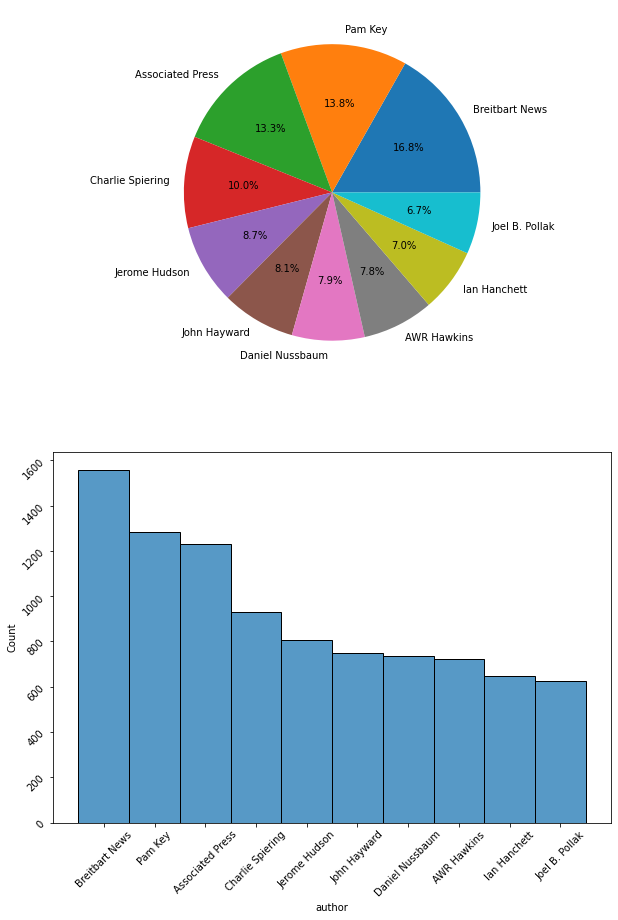

In [7]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,15))
ax1.pie(top_wirter.values.tolist(), labels=df.author.unique(), autopct="%.1f%%")
sns.histplot(df.author, ax=ax2)
ax2.tick_params(labelrotation=45)

plt.show()

### Preprocess

In [8]:
def process_row(row):
    import re
    from textblob import Word
    from string import punctuation
    from nltk.stem.snowball import SnowballStemmer
    from gensim.parsing.preprocessing import STOPWORDS
    
    
    #Mail address
    row = re.sub('(\S+@\S+)(com|\s+com)', ' ', row)
    #Username
    row = re.sub('(\S+@\S+)', ' ', row)
    #punctuation & Lower case
    punctuation = punctuation + '\n' + '—“,”‘-’' + '0123456789'
    row = ''.join(word.lower() for word in row if word not in punctuation)
    #Stopwords & Lemma
    stop = STOPWORDS
    row = ' '.join(Word(word).lemmatize() for word in row.split() if word not in stop)
    #Stemming
    stemmer = SnowballStemmer(language='english')
    row = ' '.join([stemmer.stem(word) for word in row.split() if len(word) > 2])
    #Extra whitespace
    row = re.sub('\s{1,}', ' ', row)

    return row

df['content'] = df['content'].apply(process_row)

le = LabelEncoder()
labels = to_categorical(le.fit_transform(df.author)) # One-Hot encoding


corpus = df.content.values.tolist()
corpus = [c.split() for c in corpus] # add articles in a list

# Tokenize words to tf-idf matrix
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_matrix(corpus, mode='tfidf')

# Divide the data into two categories: train and test
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=.3)

### Create model

In [9]:
model = keras.Sequential([
    Dense(16,input_shape=(sequences[0].shape), kernel_regularizer=l2(0.1)),
    Dropout(.3),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                320016    
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                170       
Total params: 320,186
Trainable params: 320,186
Non-trainable params: 0
_________________________________________________________________


### Train model

In [10]:
history = model.fit(X_train, y_train, epochs=5, validation_split=.33)

Epoch 1/5
136/136 [==============================] - 2s 10ms/step - loss: 4.6145 - accuracy: 0.4344 - val_loss: 2.8229 - val_accuracy: 0.8512
Epoch 2/5
136/136 [==============================] - 1s 4ms/step - loss: 2.4640 - accuracy: 0.9001 - val_loss: 1.9395 - val_accuracy: 0.8955
Epoch 3/5
136/136 [==============================] - 1s 4ms/step - loss: 1.6795 - accuracy: 0.9495 - val_loss: 1.4493 - val_accuracy: 0.9123
Epoch 4/5
136/136 [==============================] - 1s 4ms/step - loss: 1.2309 - accuracy: 0.9667 - val_loss: 1.1624 - val_accuracy: 0.9142
Epoch 5/5
136/136 [==============================] - 1s 4ms/step - loss: 0.9622 - accuracy: 0.9729 - val_loss: 0.9886 - val_accuracy: 0.9170


### Visualize accuracy/loss plot

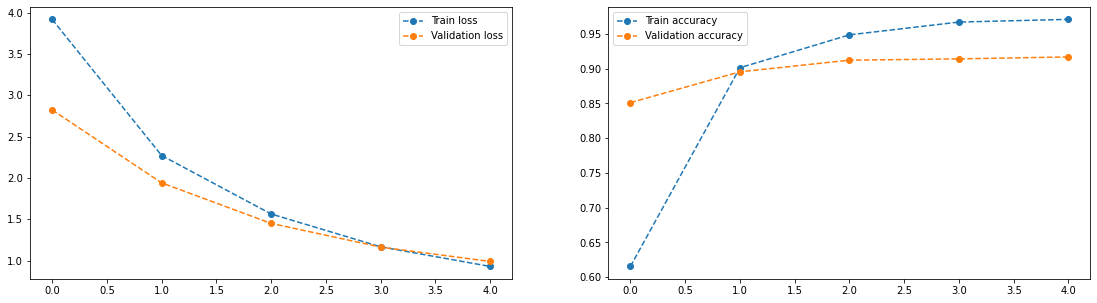

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19,5))
ax1.plot(history.epoch, history.history['loss'], 'o--', label='Train loss')
ax1.plot(history.epoch, history.history['val_loss'], 'o--', label='Validation loss')

ax2.plot(history.epoch, history.history['accuracy'], 'o--' , label='Train accuracy')
ax2.plot(history.epoch, history.history['val_accuracy'], 'o--', label='Validation accuracy',)
ax1.legend()
ax2.legend()
f.show()

### Evaluate model in test data

In [12]:
eval_ = model.evaluate(X_test, y_test)
print("Loss: {0:.5}".format(eval_[0]))
print("Accuracy: {0:.2%}".format(eval_[1]))

87/87 [==============================] - 0s 2ms/step - loss: 0.9857 - accuracy: 0.9188
Loss: 0.98572
Accuracy: 91.88%
